# Eligibility Classification

## Import Data

In [1]:
# import library
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("train_data_synthetic.csv")

In [3]:
df.head(2)

,Dokumen Lampiran Utama,Kategori pemohon,Sebab Memohon Bantuan,No. K/P (baru)/Polis/Tentera/No. Pasport,Nama Pemohon/Institusi,Alamat,Daerah,Poskod,Bandar,Negeri,...,Sumber Pendapatan Bulanan,Perbelanjaan Bulanan,Hubungan kekeluargaan dengan kakitangan LZS?,Nama Kakitangan,Pejabat (Kakitangan Berhubungan),Hubungan,Jawatan (Kakitangan Berhubungan),Tarikh,asnaf_label,label_eligibility
0,"Sijil Nikah/Cerai/Mati, Salinan KP Pemohon, Pe...",Individu,Tiada pendapatan,820304-35-3395,Chua bin Jia Hao,"No. 18, Jalan Kenanga 7, Taman Rakyat, 47304 A...",Kuala Langat,47304,Ampang Jaya,Selangor,...,"{""Diri"": 1402.1, ""Isteri/Suami/Ibu Bapa/Penjag...","{""Perbelanjaan Makan Minum"": 690.06, ""Sewa/Ans...",TIDAK,NaN,NaN,NaN,NaN,2/10/2025,FAKIR,NOT ELIGIBLE
1,"Salinan KP Pemohon, Salinan KP Tanggungan, Pen...",Individu,Makan minum,020219-28-5402,Azizah binti Abdullah,"No. 150, Jalan Anggerik 10, Taman Indah, 47304...",Sabak Bernam,47304,Shah Alam,Selangor,...,"{""Diri"": 1569.91, ""Isteri/Suami/Ibu Bapa/Penja...","{""Perbelanjaan Makan Minum"": 1237.97, ""Sewa/An...",TIDAK,NaN,NaN,NaN,NaN,3/1/2025,FAKIR,NOT ELIGIBLE


## Data Overview

In [4]:
df.dtypes

Dokumen Lampiran Utama                           object
Kategori pemohon                                 object
Sebab Memohon Bantuan                            object
No. K/P (baru)/Polis/Tentera/No. Pasport         object
Nama Pemohon/Institusi                           object
Alamat                                           object
Daerah                                           object
Poskod                                            int64
Bandar                                           object
Negeri                                           object
Kariah                                           object
Warganegara                                      object
Tarikh Lahir                                     object
Emel                                             object
No. Telefon Bimbit                               object
No. Telefon Rumah/Waris                          object
Nama waris                                       object
Tempoh Menetap di Selangor                      

In [5]:
df.isnull().sum()

Dokumen Lampiran Utama                              0
Kategori pemohon                                    0
Sebab Memohon Bantuan                               0
No. K/P (baru)/Polis/Tentera/No. Pasport            0
Nama Pemohon/Institusi                              0
Alamat                                              0
Daerah                                              0
Poskod                                              0
Bandar                                              0
Negeri                                              0
Kariah                                              0
Warganegara                                         0
Tarikh Lahir                                        0
Emel                                                0
No. Telefon Bimbit                                  0
No. Telefon Rumah/Waris                          4431
Nama waris                                       4431
Tempoh Menetap di Selangor                          0
Jantina                     

## Data Visualization

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# visualise the data
numerical_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(include=['object', 'category'])

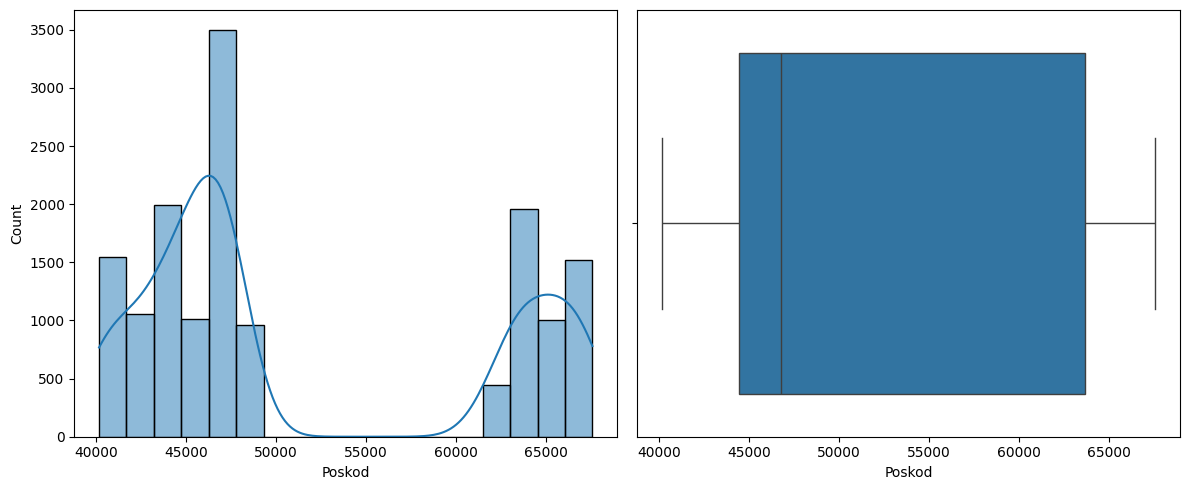

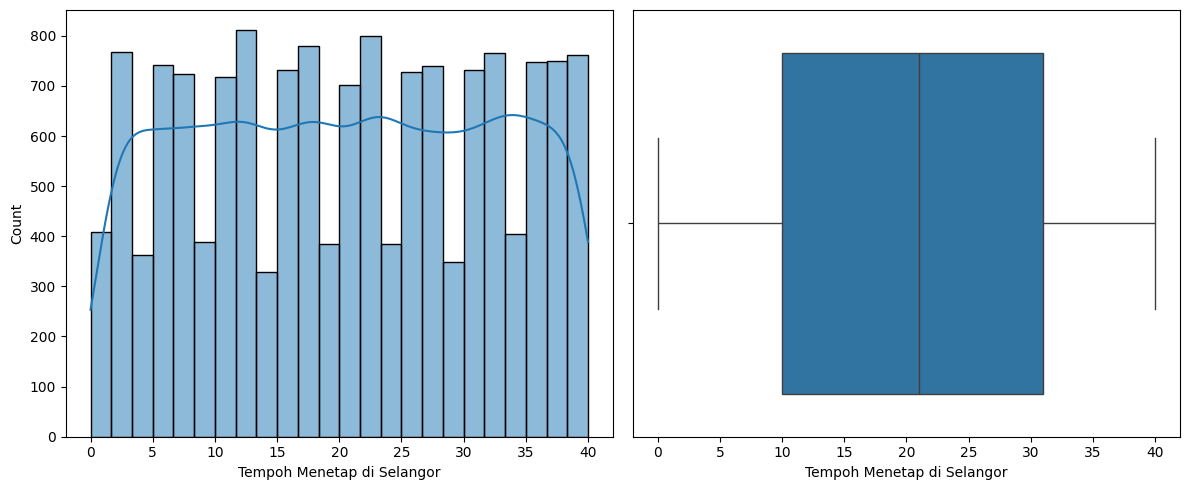

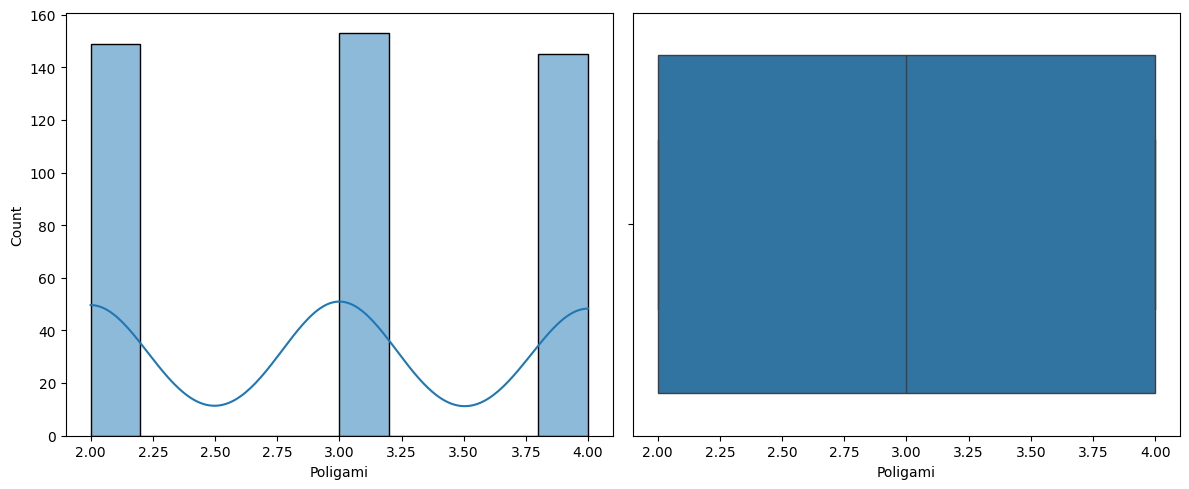

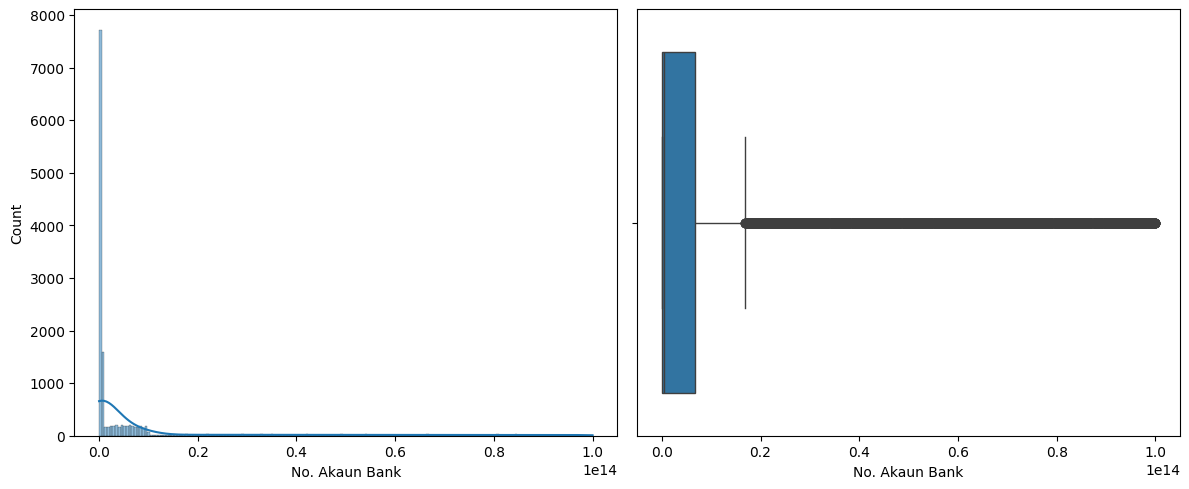

In [7]:
for feature in numerical_data:
    fig, axes = plt.subplots(1,2, figsize = (12, 5))
    sns.histplot(data=df, x=feature, kde=True, ax=axes[0])
    sns.boxplot(data=df, x=feature, ax=axes[1])

    plt.tight_layout()
    plt.show()

## Preprocessing

In [8]:
# Drop out the asnaf label
df = df.drop("asnaf_label", axis=1)
target = df["label_eligibility"]
df = df.drop("label_eligibility", axis=1)

In [9]:
# List of documents to flag
DOCUMENT_LIST = [
    "Salinan KP Pemohon", "Salinan KP Pasangan", "Salinan KP Tanggungan",
    "Kad Islam", "Penyata Bank", "Sijil Nikah/Cerai/Mati",
    "Slip Gaji", "Kad OKU", "Bil Utiliti", "Penyata KWSP",
    "Sokongan Tambahan"
]

# Function to flag presence of documents
def flag_documents(dokumen_string):
    flags = {doc: (doc in dokumen_string) for doc in DOCUMENT_LIST}
    return pd.Series(flags)

# Apply the function and create new columns
df_flags = df["Dokumen Lampiran Utama"].apply(flag_documents)

# Concatenate the original DataFrame with the flags DataFrame
df = pd.concat([df, df_flags], axis=1)

In [10]:
# Dropping out the flagged column
df = df.drop(columns=["Dokumen Lampiran Utama"])

Flattening the json format data

In [11]:
import json
# Step 1: Convert JSON-like strings to dictionaries
df["Sumber Pendapatan Bulanan"] = df["Sumber Pendapatan Bulanan"].apply(json.loads)

# Step 2: Normalize the data into a DataFrame
income_df = pd.json_normalize(df["Sumber Pendapatan Bulanan"])

# Step 3: Prepend "Sumber Pendapatan " to each column name
income_df.columns = [f"Sumber Pendapatan {col}" for col in income_df.columns]

# Step 4: Concatenate with the original DataFrame
df = pd.concat([df.drop(columns=["Sumber Pendapatan Bulanan"]), income_df], axis=1)

In [12]:
# Step 1: Convert JSON-like strings to dictionaries
df["Perbelanjaan Bulanan"] = df["Perbelanjaan Bulanan"].apply(json.loads)

# Step 2: Normalize the data into a DataFrame
expenses_df = pd.json_normalize(df["Perbelanjaan Bulanan"])

# Step 3: Prepend "Perbelanjaan " to each column name
expenses_df.columns = [f"Perbelanjaan {col}" for col in expenses_df.columns]

# Step 4: Concatenate with the original DataFrame
df = pd.concat([df.drop(columns=["Perbelanjaan Bulanan"]), expenses_df], axis=1)

Converting date of birth to age

In [13]:
# converting date of birth to age
from datetime import datetime

# Step 1: Convert the column to datetime
df['Tarikh Lahir'] = pd.to_datetime(df['Tarikh Lahir'])

# Step 2: Calculate age
today = pd.to_datetime('today')
df['age'] = df['Tarikh Lahir'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

In [14]:
df = df.drop("Tarikh Lahir", axis=1)

Flag features that might be noise but might having meanings for their existence

In [15]:
# potential noisy feature to flag
noisy_features = [
    'No. K/P (baru)/Polis/Tentera/No. Pasport',
    'Nama Pemohon/Institusi',
    'Alamat',
    'Emel',
    'No. Telefon Bimbit',
    'No. Telefon Rumah/Waris',
    'Nama waris',
    'Nama Pemegang Akaun',
    'No. Akaun Bank',
    'Nama Si Mati',
    'No. Kad Pengenalan Si Mati',
    'Nama Majikan',
    'No. Tel. Majikan',
    'Nama Kakitangan',
    'Jawatan (Kakitangan Berhubungan)',
    'Tarikh'
]

for feature in noisy_features:
    flagname = f"{feature}_flag"
    df[flagname] = df[feature].notnull().astype(int)
    df = df.drop(feature, axis=1)

In [16]:
df.columns

Index(['Kategori pemohon', 'Sebab Memohon Bantuan', 'Daerah', 'Poskod',
       'Bandar', 'Negeri', 'Kariah', 'Warganegara',
       'Tempoh Menetap di Selangor', 'Jantina', 'Tarikh Masuk Islam',
       'Kesihatan', 'Status', 'Poligami', 'Bank', 'Cara Pembayaran',
       'Sebab Pembayaran Tunai', 'Maklumat Isi Rumah', 'Pekerjaan', 'Jawatan',
       'Sebab Tidak Bekerja', 'Sektor', 'Jenis Kerja Sendiri',
       'Hubungan kekeluargaan dengan kakitangan LZS?',
       'Pejabat (Kakitangan Berhubungan)', 'Hubungan', 'Salinan KP Pemohon',
       'Salinan KP Pasangan', 'Salinan KP Tanggungan', 'Kad Islam',
       'Penyata Bank', 'Sijil Nikah/Cerai/Mati', 'Slip Gaji', 'Kad OKU',
       'Bil Utiliti', 'Penyata KWSP', 'Sokongan Tambahan',
       'Sumber Pendapatan Diri',
       'Sumber Pendapatan Isteri/Suami/Ibu Bapa/Penjaga',
       'Sumber Pendapatan Pencen/PERKESO',
       'Sumber Pendapatan Sumbangan Anak-anak',
       'Sumber Pendapatan Lain-Lain (JKM dan Sebagainya)',
       'Sumber Pendapa

In [17]:
numerical_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(include=['object', 'category']).columns

In [18]:
# Encoding categorical data
from sklearn.preprocessing import OrdinalEncoder

# OrdinalEncoder cannot handle null
df[categorical_data] = df[categorical_data].fillna("missing").astype(str)

# Step 2: Encode
encoder = OrdinalEncoder()
df[categorical_data] = encoder.fit_transform(df[categorical_data])

In [19]:
# Imputing NAN
# from sklearn.impute import SimpleImputer

# imputer =  imputer = SimpleImputer(strategy='constant', fill_value=-999)
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [20]:
target = target.map({'ELIGIBLE': 1, 'NOT ELIGIBLE': 0})

In [21]:
df.columns

Index(['Kategori pemohon', 'Sebab Memohon Bantuan', 'Daerah', 'Poskod',
       'Bandar', 'Negeri', 'Kariah', 'Warganegara',
       'Tempoh Menetap di Selangor', 'Jantina', 'Tarikh Masuk Islam',
       'Kesihatan', 'Status', 'Poligami', 'Bank', 'Cara Pembayaran',
       'Sebab Pembayaran Tunai', 'Maklumat Isi Rumah', 'Pekerjaan', 'Jawatan',
       'Sebab Tidak Bekerja', 'Sektor', 'Jenis Kerja Sendiri',
       'Hubungan kekeluargaan dengan kakitangan LZS?',
       'Pejabat (Kakitangan Berhubungan)', 'Hubungan', 'Salinan KP Pemohon',
       'Salinan KP Pasangan', 'Salinan KP Tanggungan', 'Kad Islam',
       'Penyata Bank', 'Sijil Nikah/Cerai/Mati', 'Slip Gaji', 'Kad OKU',
       'Bil Utiliti', 'Penyata KWSP', 'Sokongan Tambahan',
       'Sumber Pendapatan Diri',
       'Sumber Pendapatan Isteri/Suami/Ibu Bapa/Penjaga',
       'Sumber Pendapatan Pencen/PERKESO',
       'Sumber Pendapatan Sumbangan Anak-anak',
       'Sumber Pendapatan Lain-Lain (JKM dan Sebagainya)',
       'Sumber Pendapa

Additional preprocessing to solve error for lgbm model

In [22]:
# seems like lgbm does not support JSON character for column name
df.columns = df.columns.str.replace(r'[^\w\s]', '_', regex=True)

## Model Training

In [23]:
# Base Modeling
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=42, stratify=target)

# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_rounds': 10
}

# Train model
num_round = 100
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_label = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

# Evaluate accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred_label))  # Use y_pred_label, not y_pred
print("Classification Report:\n", classification_report(y_test, y_pred_label))  # Use y_pred_label


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4691, number of negative: 5809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4425
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446762 -> initscore=-0.213763
[LightGBM] [Info] Start training from score -0.213763
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.0786667
Accuracy: 0.9213333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      2490
           1       0.92      0.90    

## Model Explanation

Using LightGMB built-in importance explainer

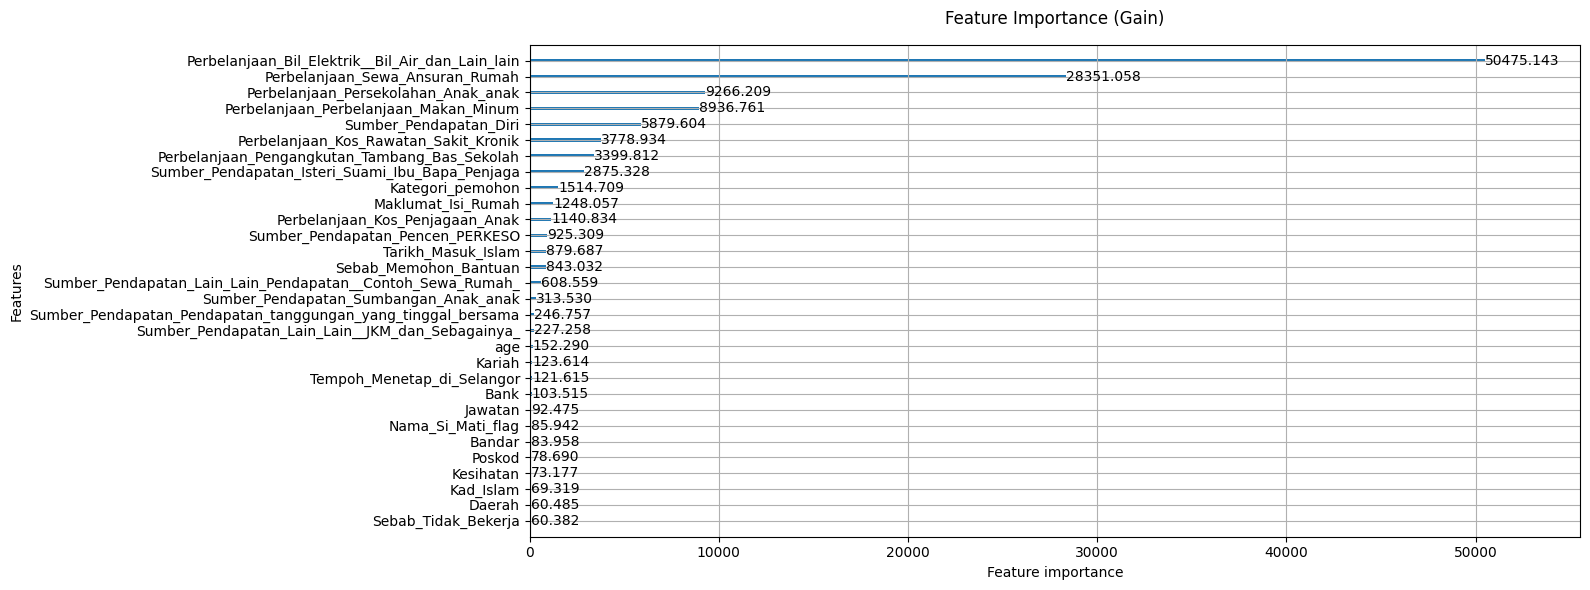

In [25]:
# ChatGPT Generated
# Plot feature importance

lgb.plot_importance(lgb_model, max_num_features=30, importance_type='gain', figsize=(16, 6))
plt.title('Feature Importance (Gain)', pad=15)
plt.tight_layout()
plt.show()

Using shap to show the importance of each features

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


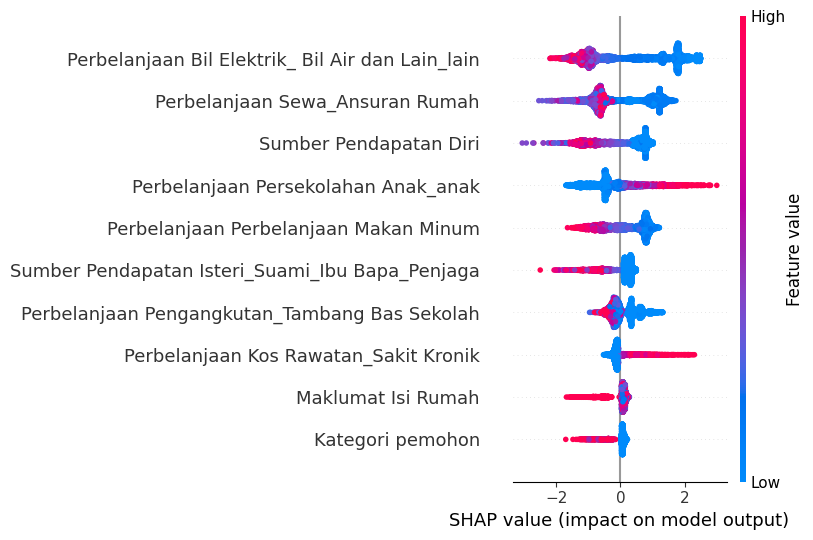

In [30]:
# ChatGPT generated code

import shap
import matplotlib.pyplot as plt

# Step 1: Create the SHAP explainer
explainer = shap.TreeExplainer(lgb_model)

# Step 2: Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Step 3: Plot the SHAP summary plot for class 1 (positive class)
shap.summary_plot(shap_values[1], X_test, max_display=10)
